In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# DATA

In [2]:
file_path = '../../src/data/temp/zbp_totals_with_features.csv'
data = pd.read_csv(file_path)
data.head()

,zip,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,est,year,naics_11_pct,...,n50_99_pct,n100_249_pct,n250_499_pct,n500_999_pct,n1000_pct,median_hh_income,total_population,total_retirement,total_midcareer (25-34),total_midcareer (35-44)
0,91901,H,4141,H,36304,H,174786,391,2012,0.000000,...,0.010230,0.005115,0.002558,0.0,0.002558,76496,17034.0,2691.0,1441.0,2011.0
1,91902,G,2265,G,19111,G,81569,349,2012,0.002865,...,0.017192,0.002865,0.000000,0.0,0.000000,86099,17659.0,3485.0,1785.0,2246.0
2,91905,G,19,S,0,H,748,9,2012,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,70000,1088.0,101.0,151.0,74.0
3,91906,D,0,D,0,D,0,27,2012,0.000000,...,0.000000,0.000000,0.037037,0.0,0.000000,54135,3679.0,395.0,559.0,277.0
4,91910,G,19799,G,200767,G,805325,1458,2012,0.000686,...,0.021262,0.013032,0.002743,0.0,0.001372,55875,73761.0,9195.0,10262.0,9164.0


In [3]:
data.columns

Index(['zip', 'emp_nf', 'emp', 'qp1_nf', 'qp1', 'ap_nf', 'ap', 'est', 'year',
       'naics_11_pct', 'naics_21_pct', 'naics_22_pct', 'naics_23_pct',
       'naics_31_pct', 'naics_42_pct', 'naics_44_pct', 'naics_48_pct',
       'naics_51_pct', 'naics_52_pct', 'naics_53_pct', 'naics_54_pct',
       'naics_55_pct', 'naics_56_pct', 'naics_61_pct', 'naics_62_pct',
       'naics_71_pct', 'naics_72_pct', 'naics_81_pct', 'naics_99_pct',
       'n1_4_pct', 'n5_9_pct', 'n10_19_pct', 'n20_49_pct', 'n50_99_pct',
       'n100_249_pct', 'n250_499_pct', 'n500_999_pct', 'n1000_pct',
       'median_hh_income', 'total_population', 'total_retirement',
       'total_midcareer (25-34)', 'total_midcareer (35-44)'],
      dtype='object')

# Exploratory Data Analysis

In below, we check for trends within the above features, Specifically how they change over time and coorelation with the number of establishments (est)

Check the hypotheses from the paper that inspired our feature selection

## Coorelation Matrix

In [4]:
corr = data.drop(columns=['emp_nf', 'qp1_nf', 'ap_nf']).corr()
corr[['est']].sort_values('est', ascending=False).style.background_gradient(cmap='coolwarm')

,est
est,1.000000
emp,0.863146
ap,0.692688
qp1,0.686603
n20_49_pct,0.562667
naics_55_pct,0.525516
n50_99_pct,0.507124
naics_51_pct,0.489608
n100_249_pct,0.470827
total_midcareer (35-44),0.460927


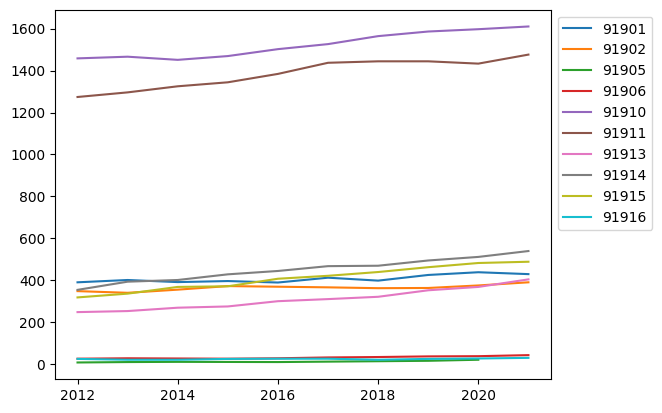

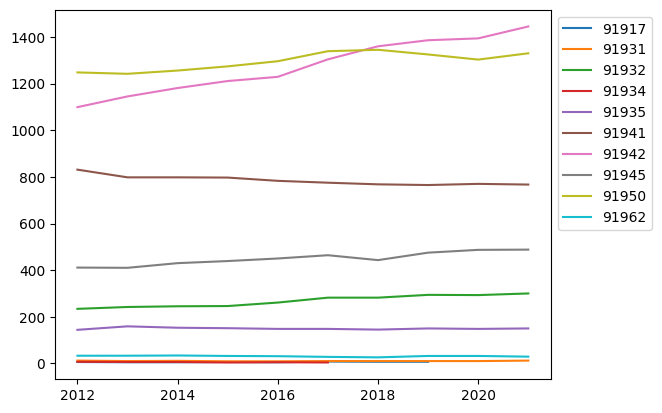

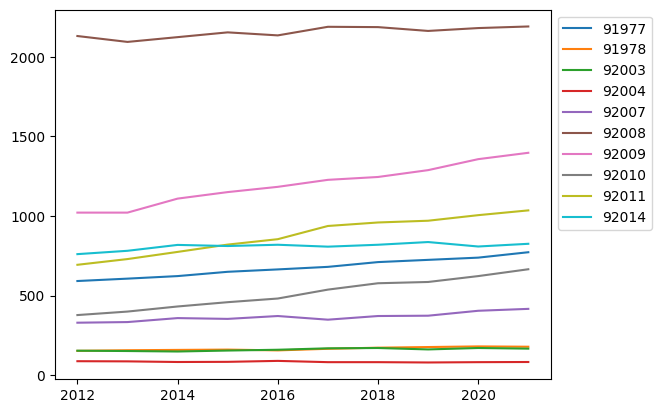

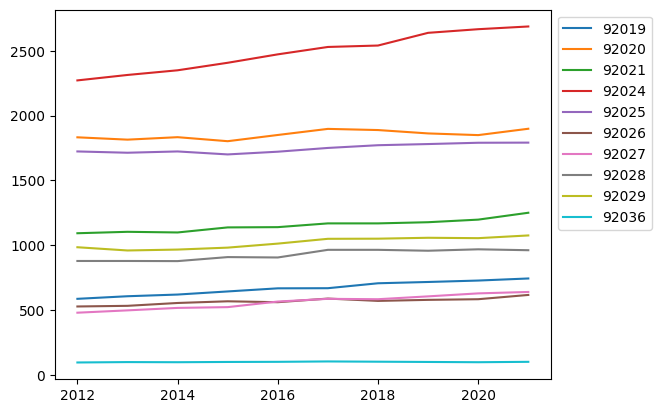

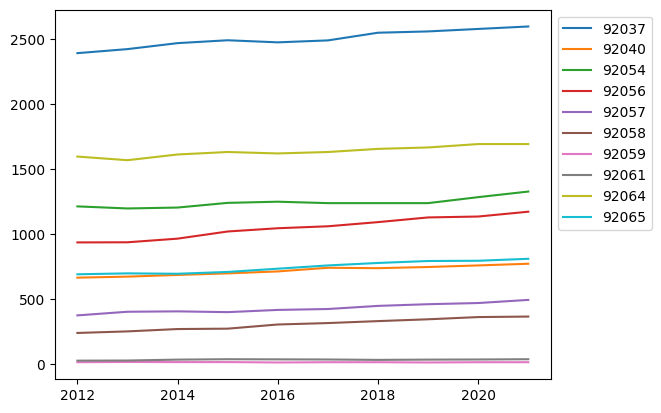

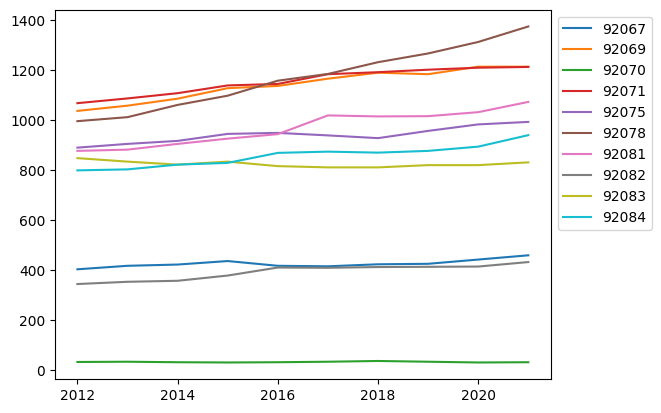

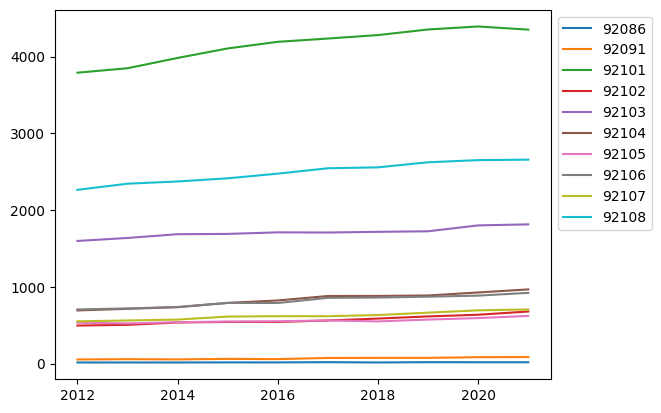

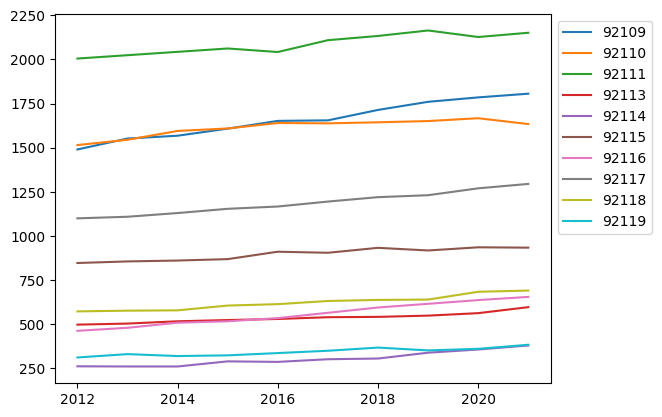

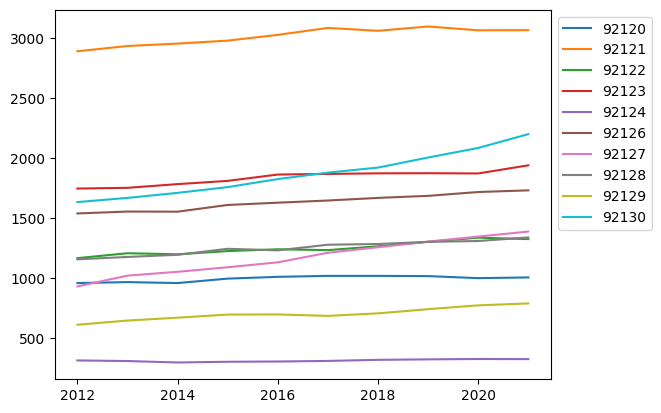

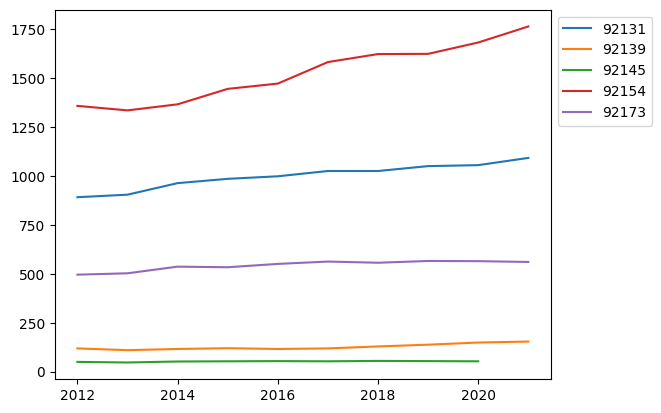

In [5]:
i = 0
for curr_zip in data['zip'].unique():
    i += 1
    curr_data = data[data['zip']==curr_zip]
    plt.plot(curr_data['year'], curr_data['est'], label=curr_zip)
    
    if i % 10 == 0:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.figure()
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

## Top Zipcodes

<Axes: xlabel='zip'>

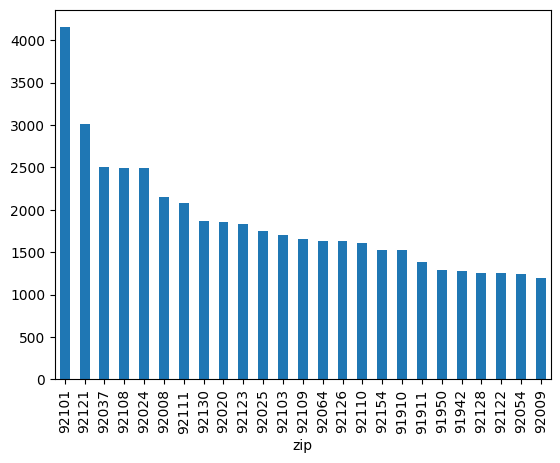

In [6]:
data.groupby('zip')['est'].mean().sort_values(ascending=False).head(25).plot(kind='bar')

<Axes: xlabel='zip'>

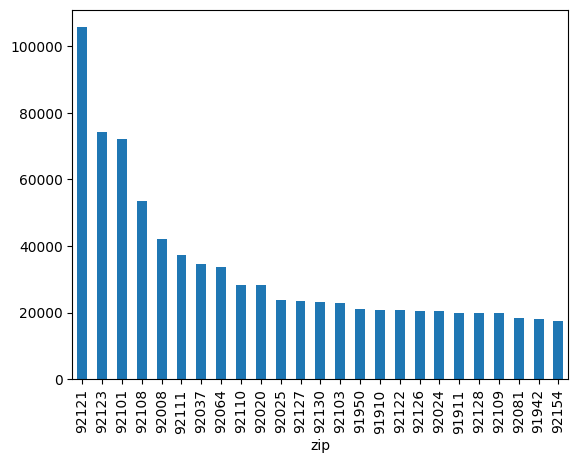

In [7]:
data.groupby('zip')['emp'].mean().sort_values(ascending=False).head(25).plot(kind='bar')

<Axes: xlabel='zip'>

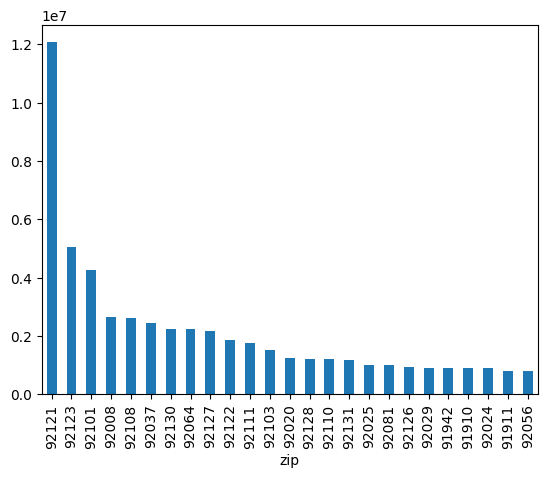

In [8]:
data.groupby('zip')['ap'].mean().sort_values(ascending=False).head(25).plot(kind='bar')

<Axes: xlabel='zip'>

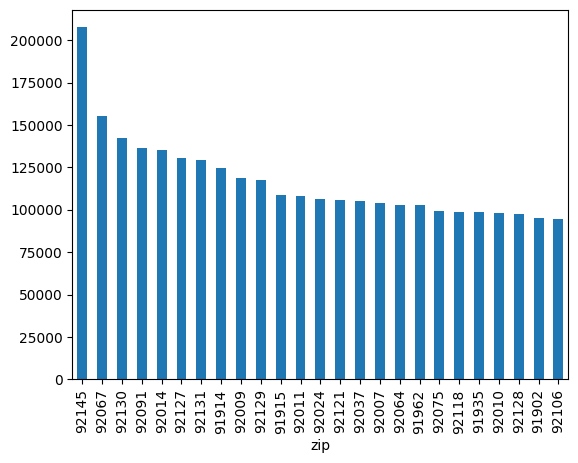

In [9]:
data.groupby('zip')['median_hh_income'].mean().sort_values(ascending=False).head(25).plot(kind='bar')

<Axes: xlabel='zip'>

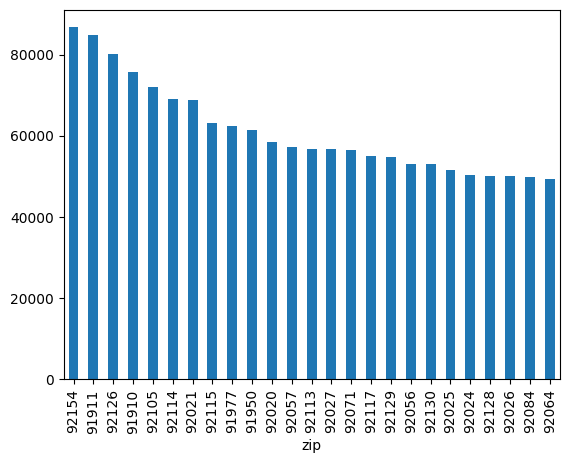

In [10]:
data.groupby('zip')['total_population'].mean().sort_values(ascending=False).head(25).plot(kind='bar')

<Axes: xlabel='zip'>

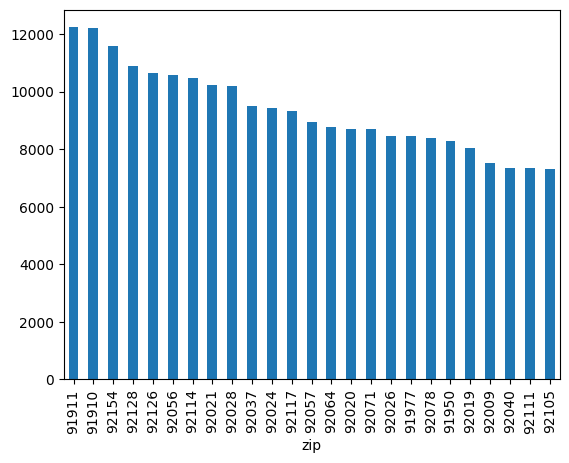

In [11]:
data.groupby('zip')['total_retirement'].mean().sort_values(ascending=False).head(25).plot(kind='bar')

<Axes: xlabel='zip'>

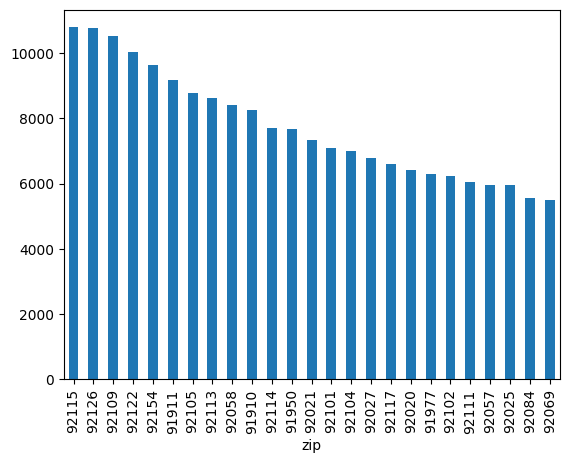

In [14]:
data.groupby('zip')['total_midcareer (25-34)'].mean().sort_values(ascending=False).head(25).plot(kind='bar')

<Axes: xlabel='zip'>

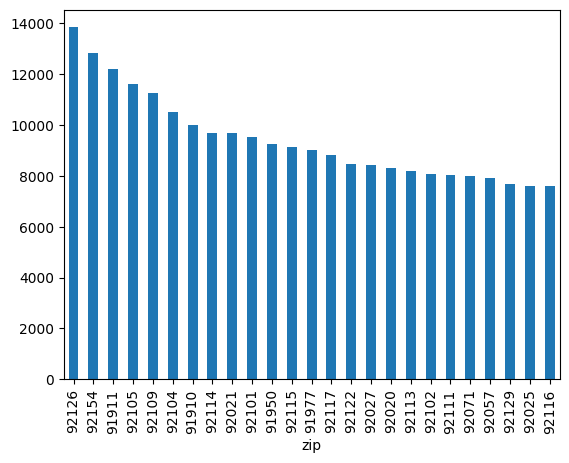

In [16]:
data.groupby('zip')['total_midcareer (35-44)'].mean().sort_values(ascending=False).head(25).plot(kind='bar')

<Axes: xlabel='zip'>

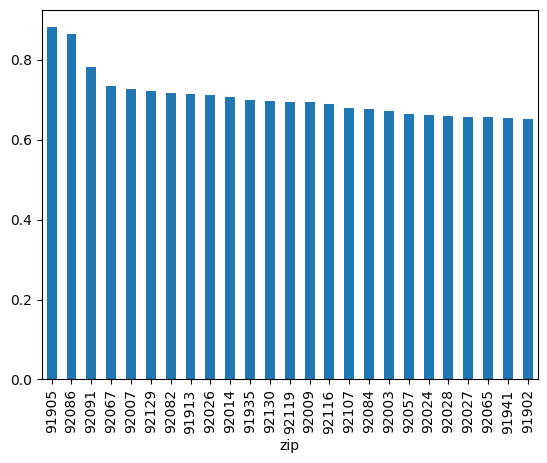

In [17]:
data.groupby('zip')['n1_4_pct'].mean().sort_values(ascending=False).head(25).plot(kind='bar')

<Axes: xlabel='zip'>

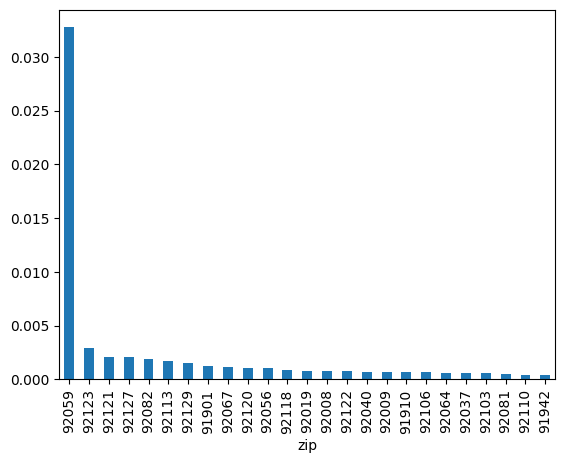

In [18]:
data.groupby('zip')['n1000_pct'].mean().sort_values(ascending=False).head(25).plot(kind='bar')

<Axes: xlabel='zip'>

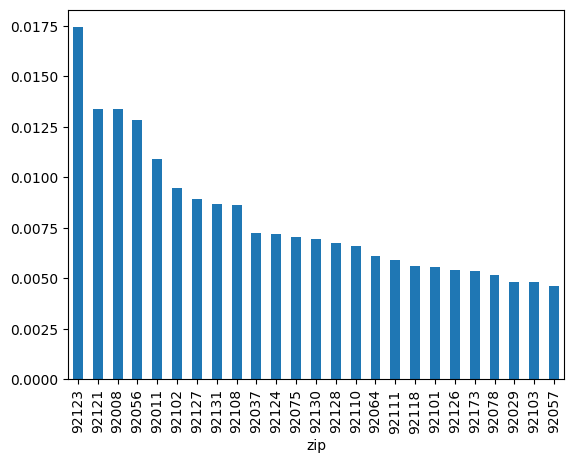

In [19]:
data.groupby('zip')['naics_55_pct'].mean().sort_values(ascending=False).head(25).plot(kind='bar')

## Number of Mid-Career Adults

<Axes: xlabel='total_midcareer (25-34)', ylabel='est'>

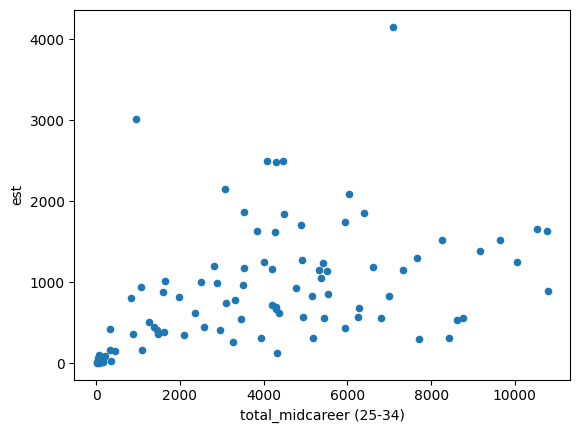

In [23]:
data.groupby('zip')[['total_midcareer (25-34)', 'est']].mean().plot(kind='scatter', x='total_midcareer (25-34)', y='est')

<Axes: xlabel='total_midcareer (35-44)', ylabel='est'>

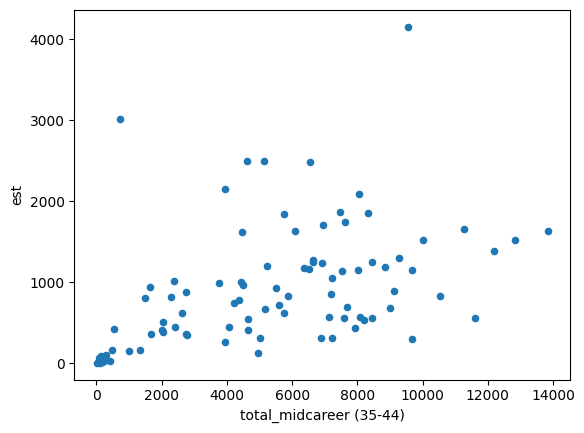

In [25]:
data.groupby('zip')[['total_midcareer (35-44)', 'est']].mean().plot(kind='scatter', x='total_midcareer (35-44)', y='est')

## Greater Personal Wealth

<Axes: xlabel='median_hh_income', ylabel='est'>

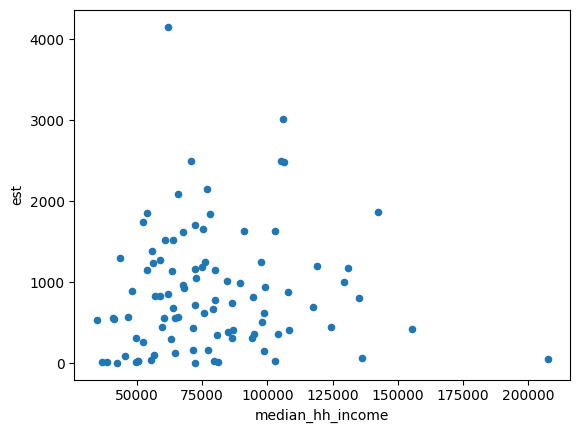

In [26]:
data.groupby('zip')[['median_hh_income', 'est']].mean().plot(kind='scatter', x='median_hh_income', y='est')

## Population Growth

<Axes: xlabel='emp', ylabel='est'>

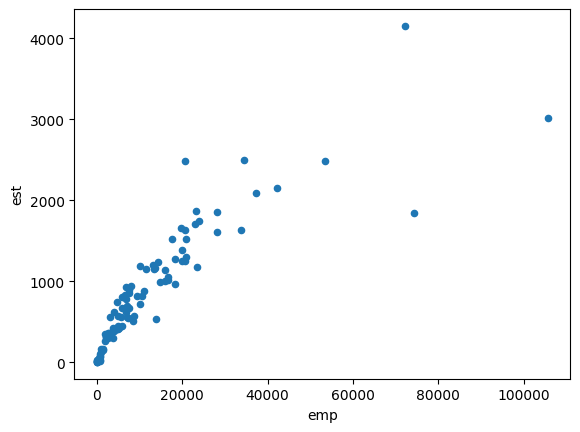

In [27]:
data.groupby('zip')[['emp', 'est']].mean().plot(kind='scatter', x='emp', y='est')

## Economic Diversity = More Smaller Organizations

<Axes: xlabel='n1_4_pct', ylabel='est'>

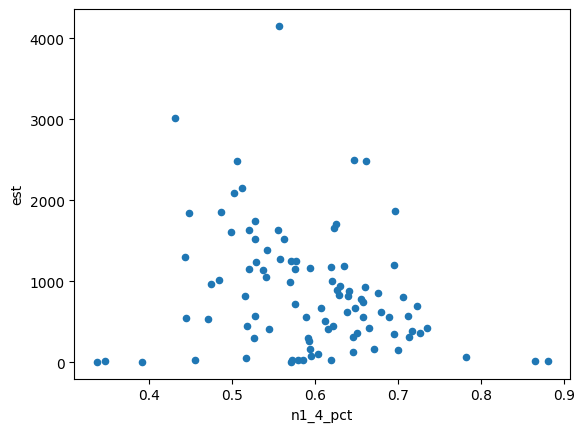

In [28]:
data.groupby('zip')[['n1_4_pct', 'est']].mean().plot(kind='scatter', x='n1_4_pct', y='est')

<Axes: xlabel='ap', ylabel='est'>

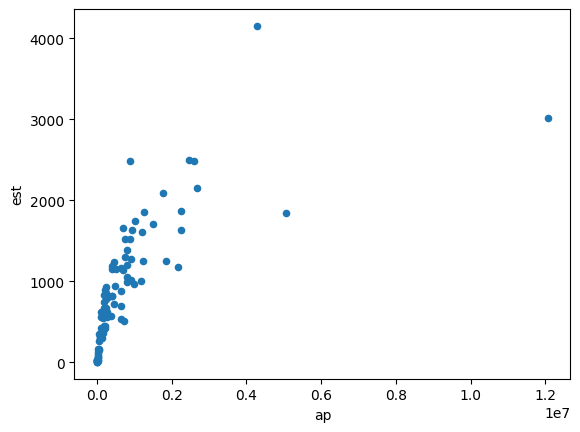

In [29]:
data.groupby('zip')[['ap', 'est']].mean().plot(kind='scatter', x='ap', y='est')

## Distribution of Business Sizes

In [30]:
data[['n1_4_pct', 'n5_9_pct', 'n10_19_pct', 'n20_49_pct', 'n50_99_pct',
       'n100_249_pct', 'n250_499_pct', 'n500_999_pct', 'n1000_pct']].mean()

n1_4_pct        0.594875
n5_9_pct        0.155794
n10_19_pct      0.103224
n20_49_pct      0.065894
n50_99_pct      0.019195
n100_249_pct    0.009729
n250_499_pct    0.001952
n500_999_pct    0.000384
n1000_pct       0.000663
dtype: float64

## Distrubution of Business Industries

In [31]:
data[['naics_11_pct', 'naics_21_pct', 'naics_22_pct', 'naics_23_pct',
       'naics_31_pct', 'naics_42_pct', 'naics_44_pct', 'naics_48_pct',
       'naics_51_pct', 'naics_52_pct', 'naics_53_pct', 'naics_54_pct',
       'naics_55_pct', 'naics_56_pct', 'naics_61_pct', 'naics_62_pct',
       'naics_71_pct', 'naics_72_pct', 'naics_81_pct', 'naics_99_pct']].mean().sort_values(ascending=False)

naics_54_pct    0.142288
naics_23_pct    0.116530
naics_44_pct    0.115465
naics_62_pct    0.110339
naics_72_pct    0.099274
naics_81_pct    0.085382
naics_53_pct    0.072899
naics_56_pct    0.050904
naics_52_pct    0.048913
naics_42_pct    0.046360
naics_31_pct    0.031902
naics_48_pct    0.020642
naics_71_pct    0.017107
naics_61_pct    0.016339
naics_51_pct    0.014236
naics_22_pct    0.003602
naics_55_pct    0.003066
naics_11_pct    0.002797
naics_99_pct    0.001674
naics_21_pct    0.000280
dtype: float64

## Total Mid-Career Feature w/ Ages (25-34) Sharply Declining 2016-2017

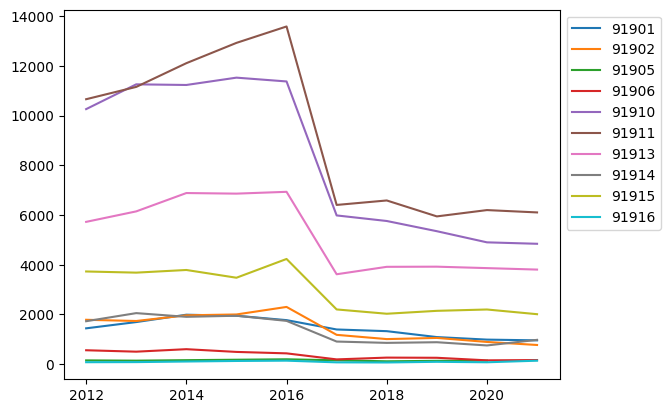

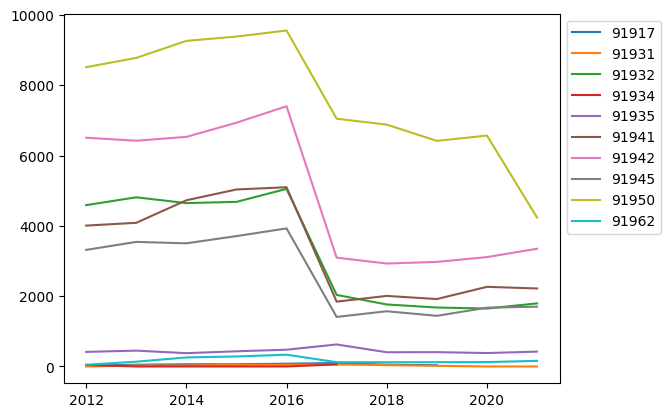

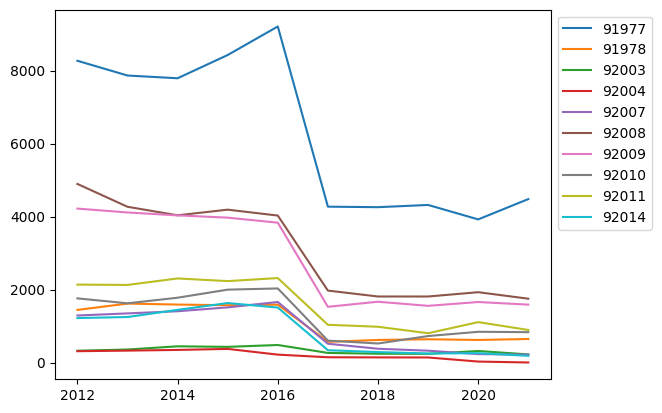

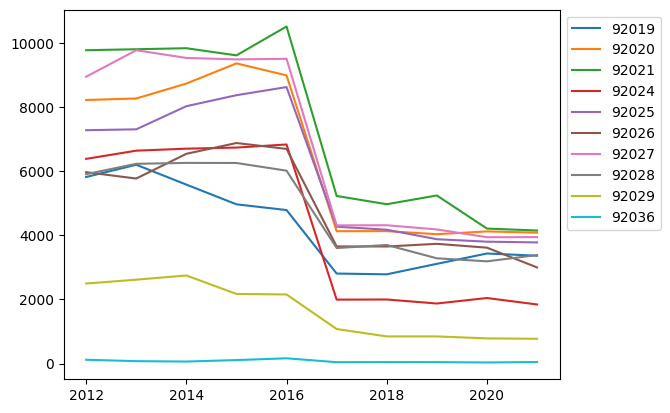

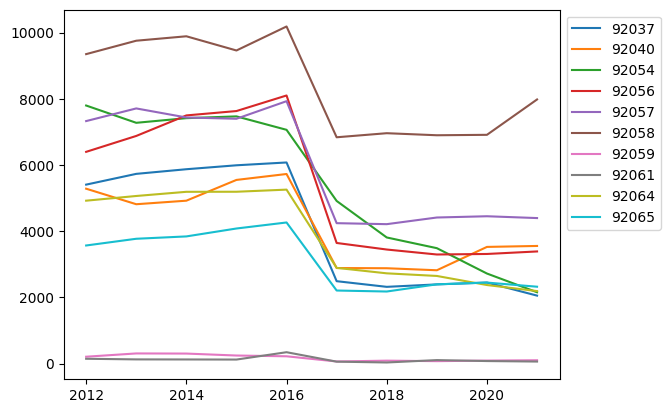

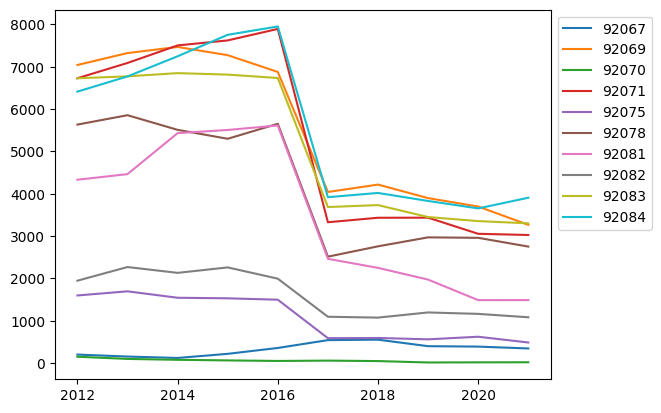

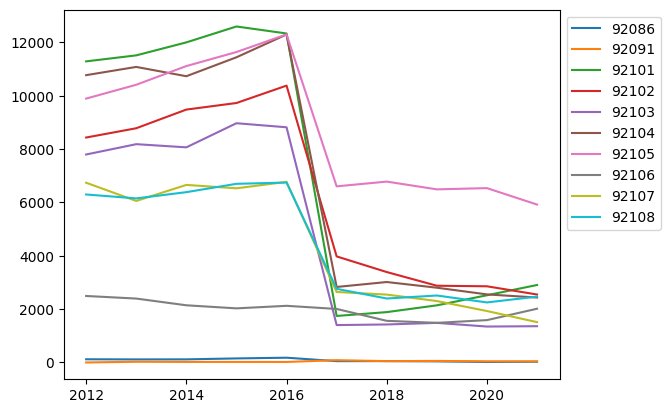

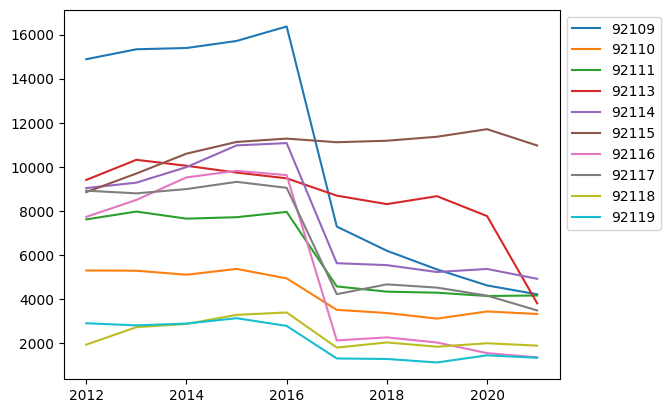

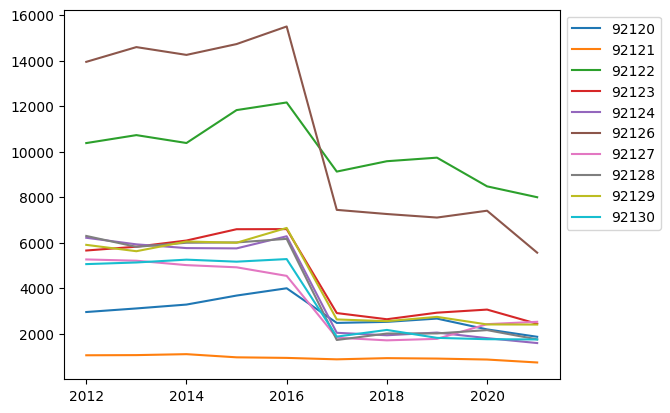

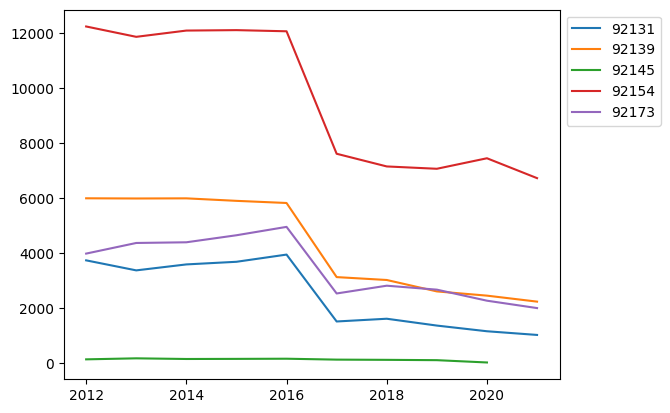

In [35]:
i = 0
for curr_zip in data['zip'].unique():
    i += 1
    curr_data = data[data['zip']==curr_zip]
    plt.plot(curr_data['year'], curr_data['total_midcareer (25-34)'], label=curr_zip)
    
    if i % 10 == 0:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.figure()
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

## Total Mid-Career Feature w/ Ages (35-44) Sharply Rising 2016-2017

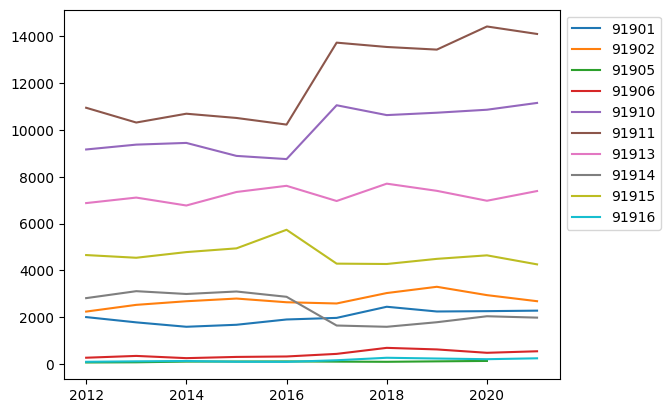

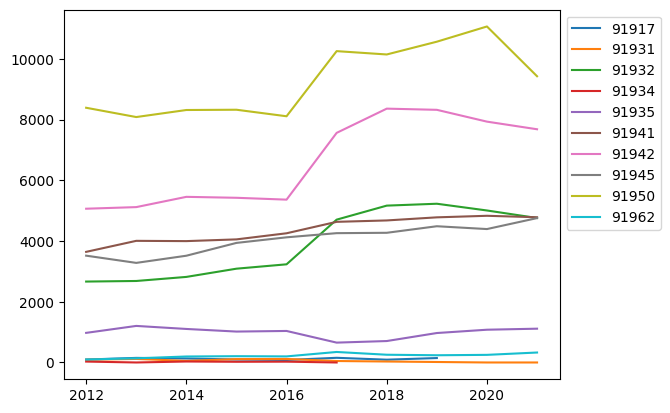

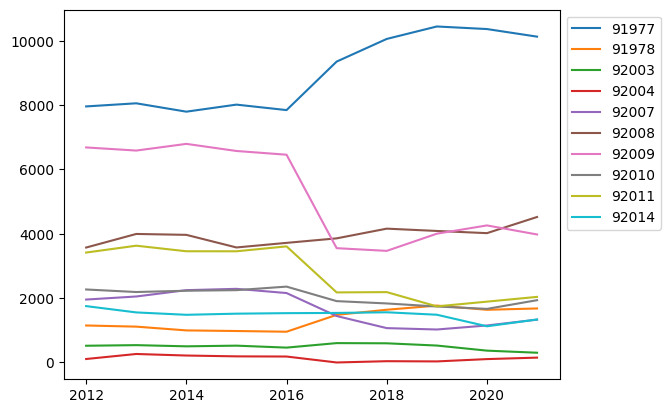

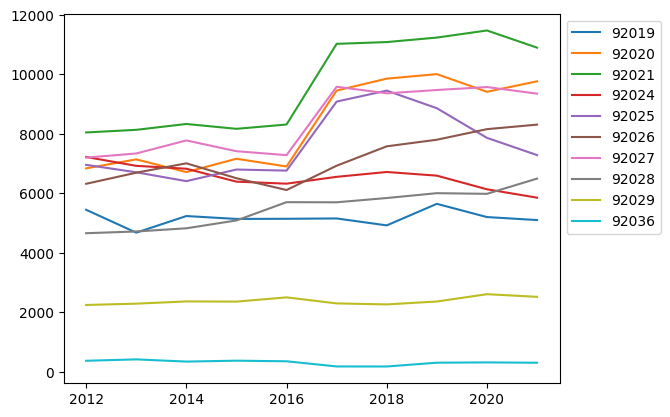

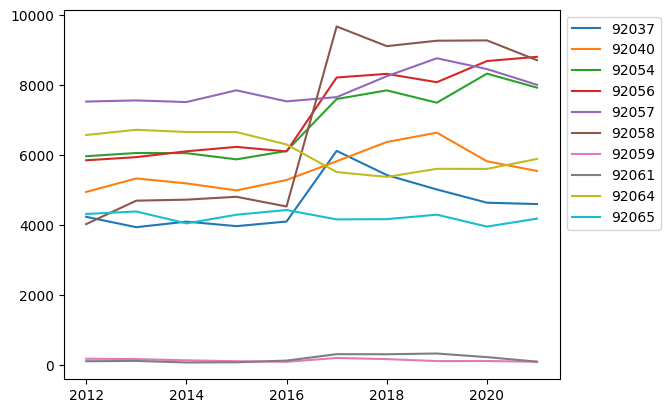

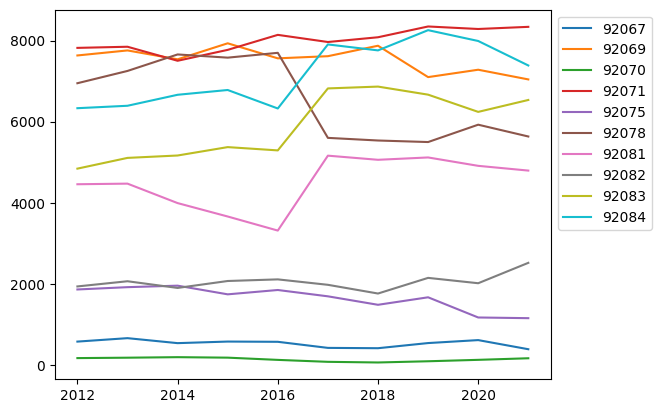

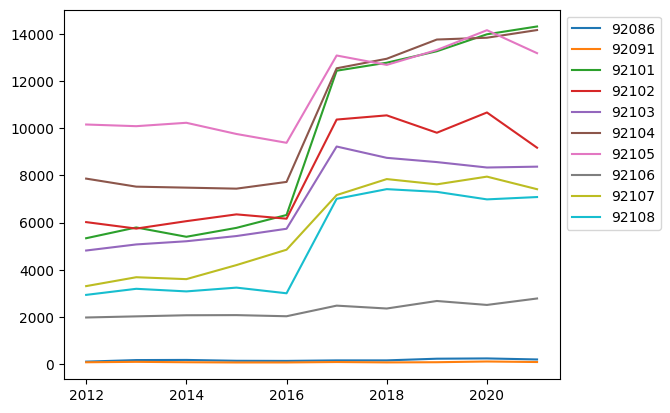

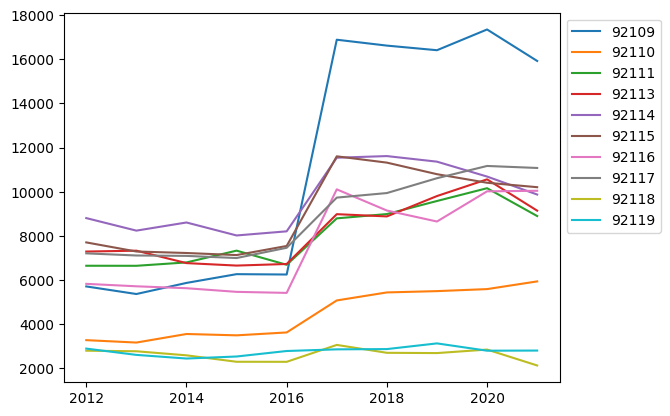

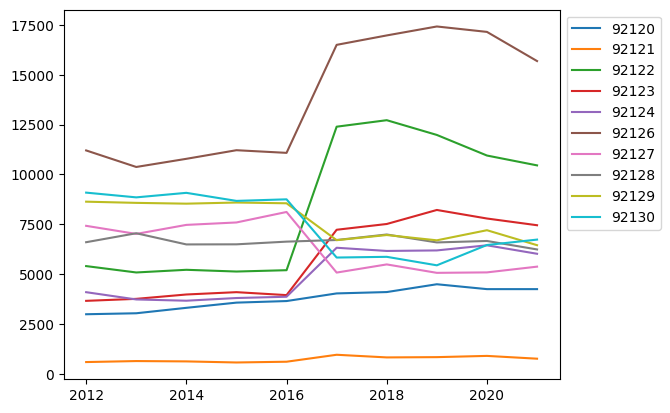

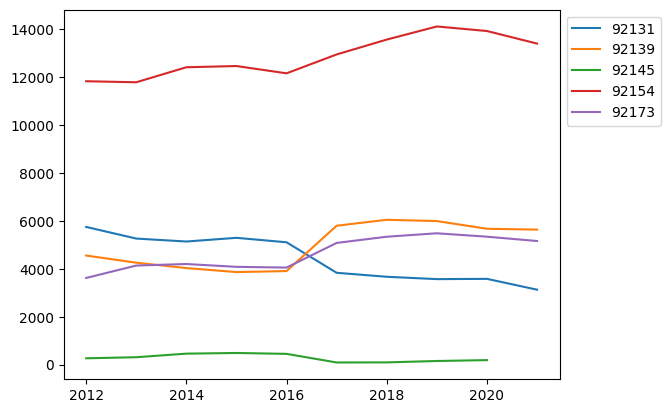

In [37]:
i = 0
for curr_zip in data['zip'].unique():
    i += 1
    curr_data = data[data['zip']==curr_zip]
    plt.plot(curr_data['year'], curr_data['total_midcareer (35-44)'], label=curr_zip)
    
    if i % 10 == 0:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.figure()
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

San Diego has had trouble retaining it's young adult population, as a result, we split the Mid-Career feature into two groups: 25-34 years and 35-44 years to try to gain more detailed insights.

## Total Retirement Rising

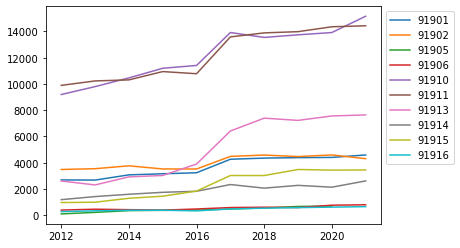

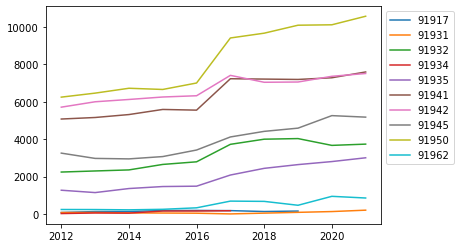

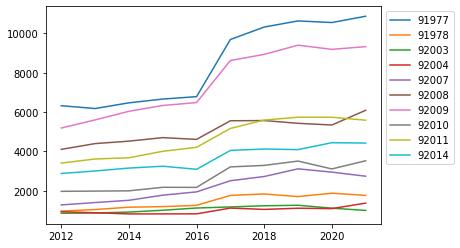

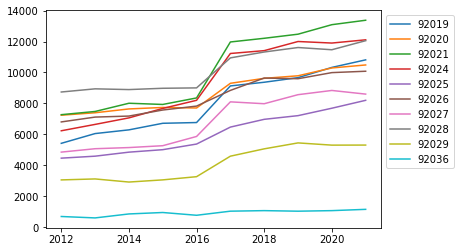

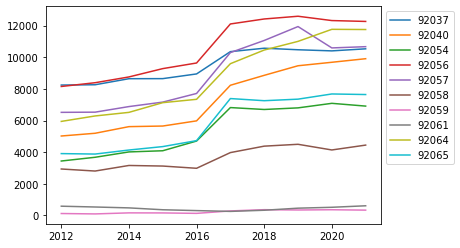

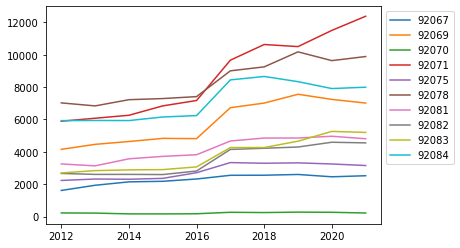

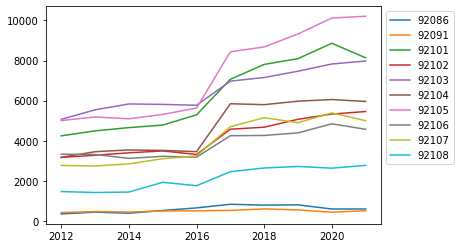

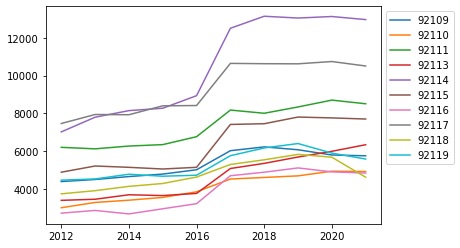

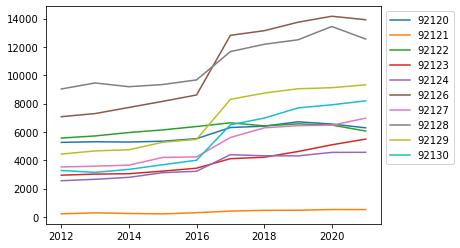

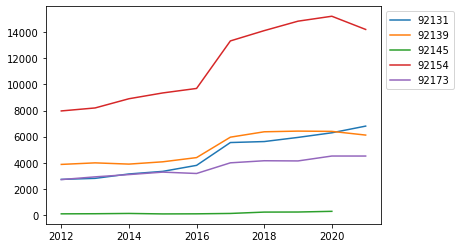

In [30]:
i = 0
for curr_zip in data['zip'].unique():
    i += 1
    curr_data = data[data['zip']==curr_zip]
    plt.plot(curr_data['year'], curr_data['total_retirement'], label=curr_zip)
    
    if i % 10 == 0:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.figure()
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

### Sharp increase in Total Retirement population from 2016-2017. Large generation group entering retirement age?

## Median Household Income Rising

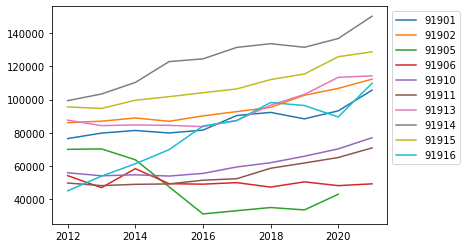

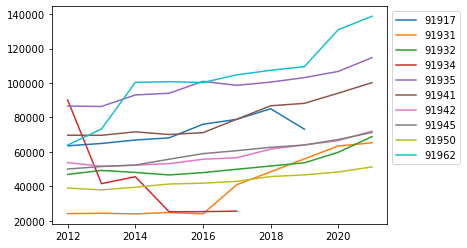

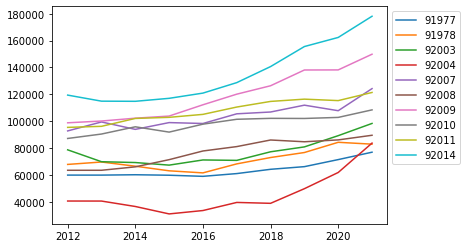

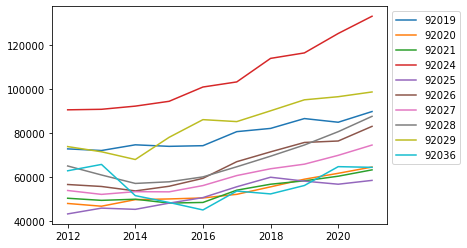

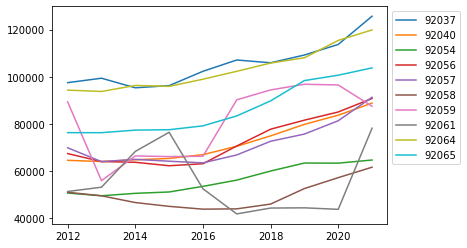

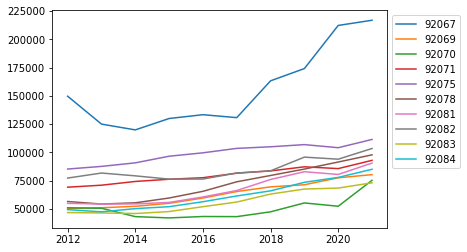

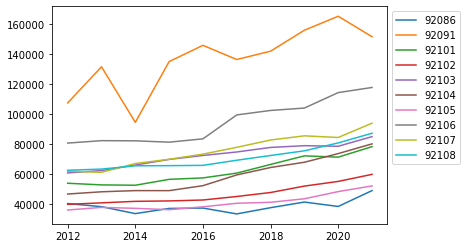

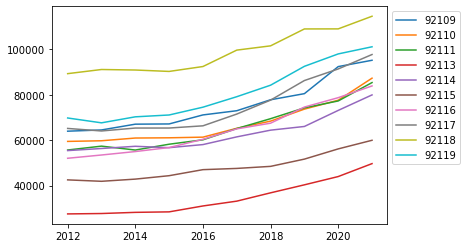

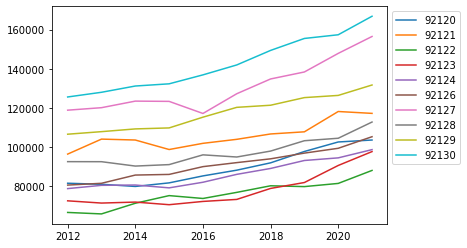

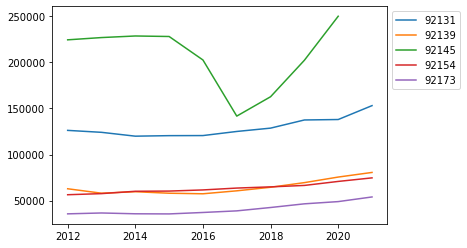

In [32]:
i = 0
for curr_zip in data['zip'].unique():
    i += 1
    curr_data = data[data['zip']==curr_zip]
    plt.plot(curr_data['year'], curr_data['median_hh_income'], label=curr_zip)
    
    if i % 10 == 0:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.figure()
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

## Population Not Changing Significantly

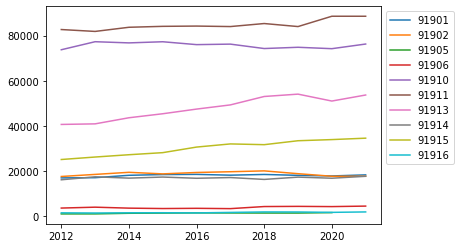

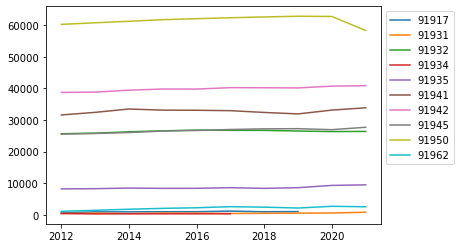

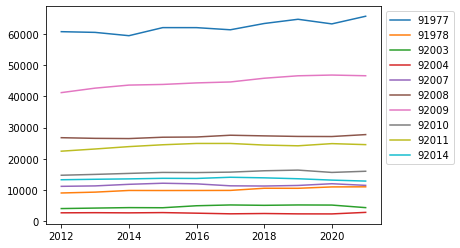

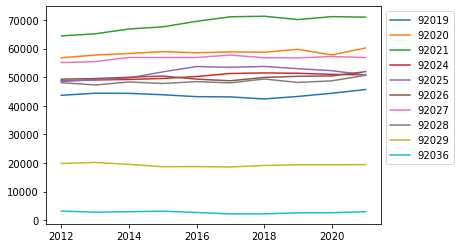

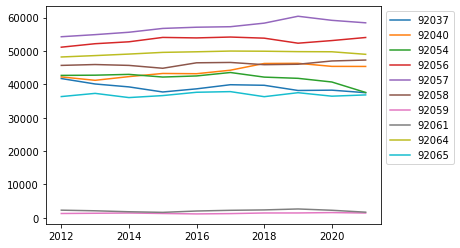

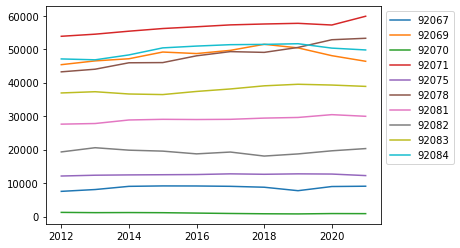

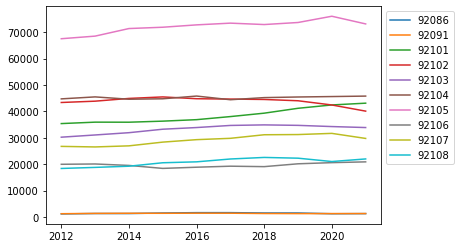

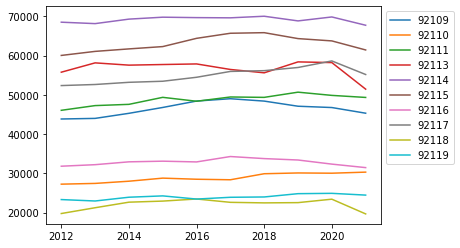

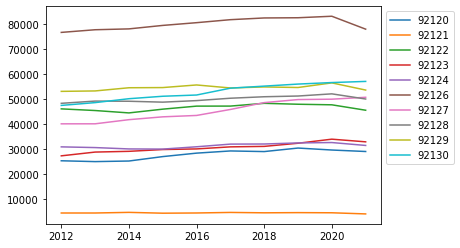

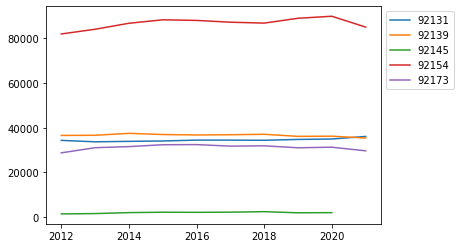

In [33]:
i = 0
for curr_zip in data['zip'].unique():
    i += 1
    curr_data = data[data['zip']==curr_zip]
    plt.plot(curr_data['year'], curr_data['total_population'], label=curr_zip)
    
    if i % 10 == 0:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.figure()
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

## Annual Payroll Rising

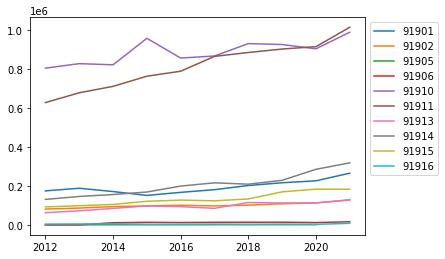

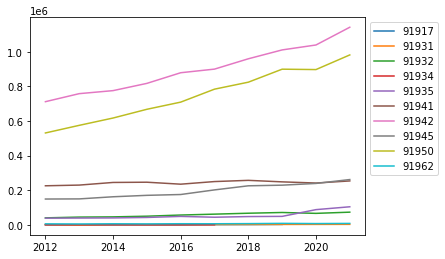

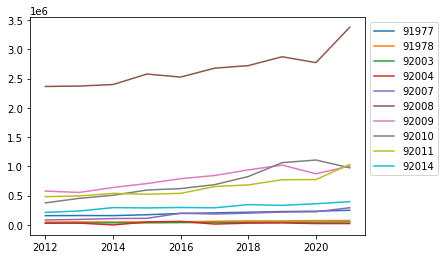

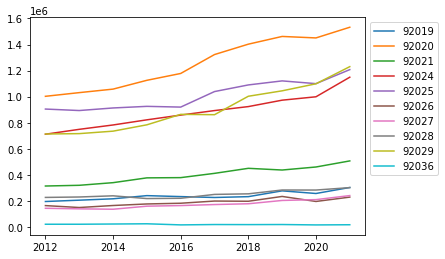

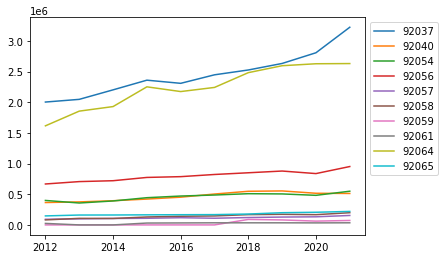

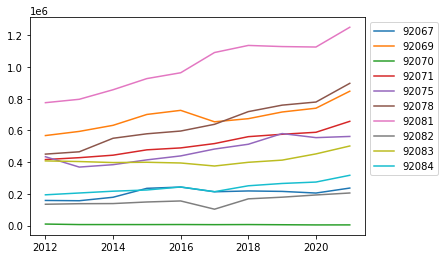

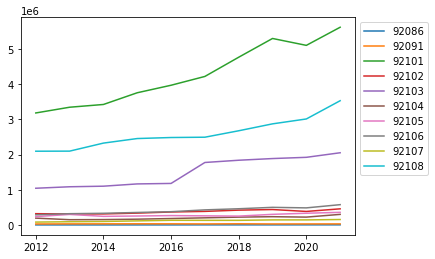

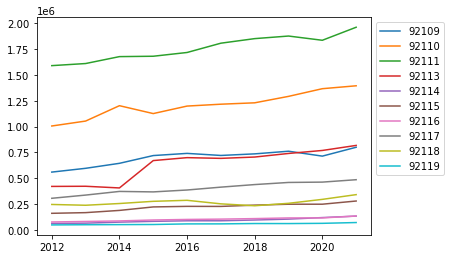

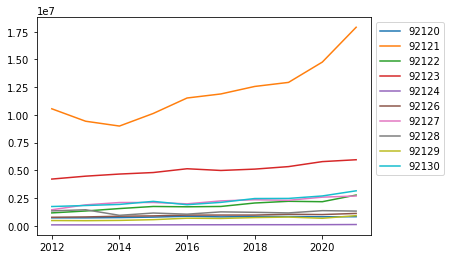

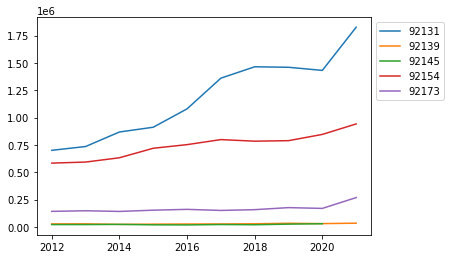

In [34]:
i = 0
for curr_zip in data['zip'].unique():
    i += 1
    curr_data = data[data['zip']==curr_zip]
    plt.plot(curr_data['year'], curr_data['ap'], label=curr_zip)
    
    if i % 10 == 0:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.figure()
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))